# Final Poster Assignment
# 05/03/25
# EESC BC3050
## Matthew-David Ilomuanya

In [12]:
# Importing Libraries
import pandas as pd           
import numpy as np           
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from datetime import datetime 

In [4]:
# Load the uploaded Zillow county-level housing data
df = pd.read_csv('County_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv')

# Display the first few rows and basic info
df.head(), df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3073 entries, 0 to 3072
Columns: 312 entries, RegionID to 2025-03-31
dtypes: float64(303), int64(4), object(5)
memory usage: 7.3+ MB


(   RegionID  SizeRank          RegionName RegionType StateName State  \
 0      3101         0  Los Angeles County     county        CA    CA   
 1       139         1         Cook County     county        IL    IL   
 2      1090         2       Harris County     county        TX    TX   
 3      2402         3     Maricopa County     county        AZ    AZ   
 4      2841         4    San Diego County     county        CA    CA   
 
                                   Metro  StateCodeFIPS  MunicipalCodeFIPS  \
 0    Los Angeles-Long Beach-Anaheim, CA              6                 37   
 1    Chicago-Naperville-Elgin, IL-IN-WI             17                 31   
 2  Houston-The Woodlands-Sugar Land, TX             48                201   
 3             Phoenix-Mesa-Chandler, AZ              4                 13   
 4    San Diego-Chula Vista-Carlsbad, CA              6                 73   
 
       2000-01-31  ...     2024-06-30     2024-07-31     2024-08-31  \
 0  213710.615288  

In [5]:
## cleaning up the Data

# Step 1: Keep relevant identifying columns and drop the rest
df_clean = df[['RegionName', 'State', 'Metro'] + list(df.columns[11:])].copy()

# Step 2: Set index and use stack to reshape manually (instead of pd.melt)
df_indexed = df_clean.set_index(['RegionName', 'State', 'Metro'])
df_stacked = df_indexed.stack().reset_index()

# Step 3: Rename columns
df_stacked.columns = ['RegionName', 'State', 'Metro', 'Date', 'ZHVI']

# Step 4: Convert 'Date' to datetime
df_stacked['Date'] = pd.to_datetime(df_stacked['Date'])

# Step 5: Drop any missing values (optional)
df_stacked.dropna(subset=['ZHVI'], inplace=True)

In [20]:
## analyzing the data

# Redefine start and end based on dates
start = df_stacked[df_stacked['Date'] == '2020-01-31']
end = df_stacked[df_stacked['Date'] == '2023-01-31']

# Merge to compute percent change
merged = pd.merge(start, end, on=['RegionName', 'State', 'Metro'], suffixes=('_2020', '_2023'))
merged['Percent_Change'] = ((merged['ZHVI_2023'] - merged['ZHVI_2020']) / merged['ZHVI_2020']) * 100

# Calculate top 10% threshold
top_10_percent_threshold = merged['Percent_Change'].quantile(0.90)

# Get RegionNames in top 10%
top_10_percent = merged[merged['Percent_Change'] >= top_10_percent_threshold]['RegionName'].tolist()

# Filter original long dataframe for those counties
df_subset = df_stacked[df_stacked['RegionName'].isin(top_10_percent)]

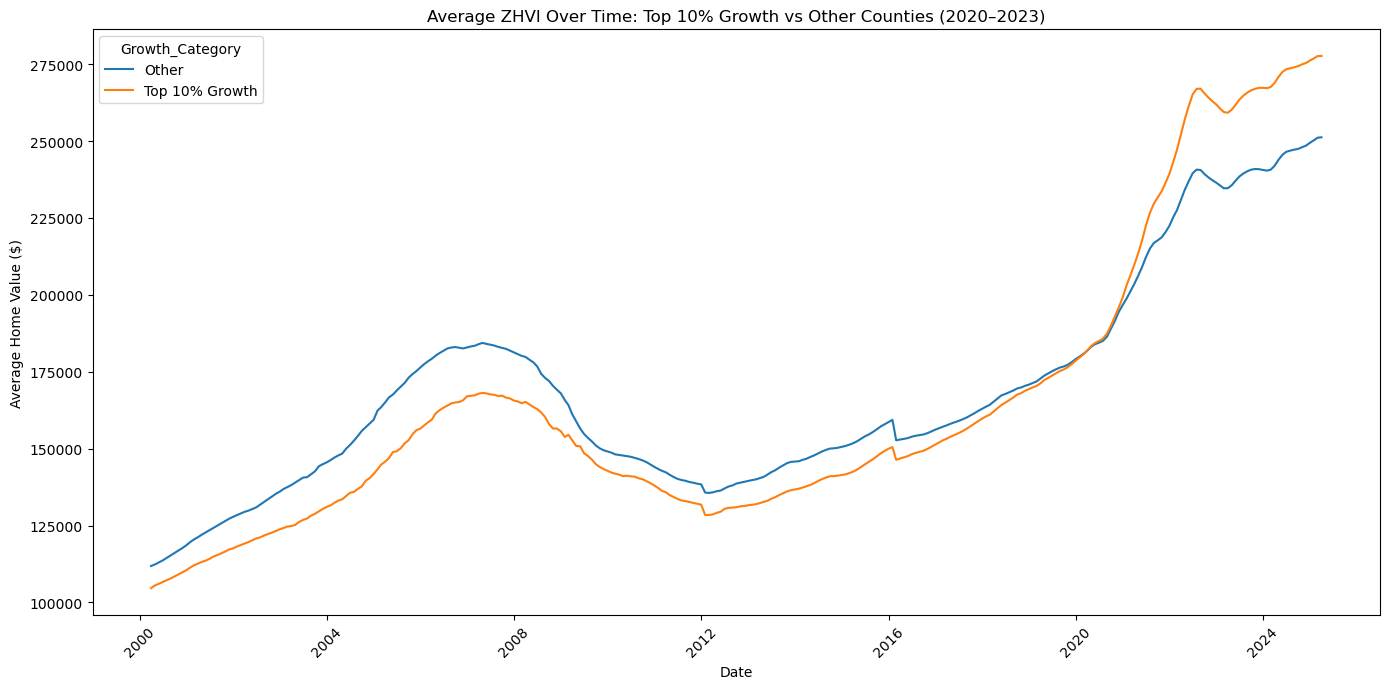

In [21]:
## Displaying the data
# Label counties in df_stacked as Top 10% or Other
df_stacked['Growth_Category'] = df_stacked['RegionName'].apply(
    lambda x: 'Top 10% Growth' if x in top_10_percent else 'Other'
)

# Group by date and category, then average ZHVI
df_grouped_plot = df_stacked.groupby(['Date', 'Growth_Category'])['ZHVI'].mean().reset_index()

# Plot line chart comparing top 10% vs other counties
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_grouped_plot, x='Date', y='ZHVI', hue='Growth_Category')
plt.title('Average ZHVI Over Time: Top 10% Growth vs Other Counties (2020–2023)')
plt.ylabel('Average Home Value ($)')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Figure 1: Average ZHVI Trends – Top 10% Growth vs Other Counties (2020–2023)

This line graph visualizes the average Zillow Home Value Index (ZHVI) over time for U.S. counties in the top 10% of housing price growth compared to all other counties, between January 2020 and January 2023. The x-axis shows the date, while the y-axis represents average home values. The plot reveals a clear divergence, with top growth counties experiencing steeper and more sustained increases in home prices, particularly during and after the COVID-19 pandemic. This trend highlights the unequal pace of housing appreciation across regions.


In [24]:
# Re-pivot the full dataset to compute volatility across all counties
df_pivot_all = df_grouped.pivot(index='Date', columns='RegionName', values='ZHVI')

# Calculate rolling standard deviation (12-month) across all counties
rolling_std_all = df_pivot_all.rolling(window=12).std()

# Average volatility across time for each county
avg_volatility_all = rolling_std_all.mean().sort_values(ascending=False)

# Get top 10% most volatile counties
volatility_threshold = avg_volatility_all.quantile(0.90)
top_10pct_volatile_all = avg_volatility_all[avg_volatility_all >= volatility_threshold].index.tolist()

# Label counties as Top 10% Volatile or Other in original grouped data
df_grouped['Volatility_Category'] = df_grouped['RegionName'].apply(
    lambda x: 'Top 10% Volatile' if x in top_10pct_volatile_all else 'Other'
)

# Group by Date and Volatility Category to get average ZHVI
df_vol_trend_all = df_grouped.groupby(['Date', 'Volatility_Category'])['ZHVI'].mean().reset_index()

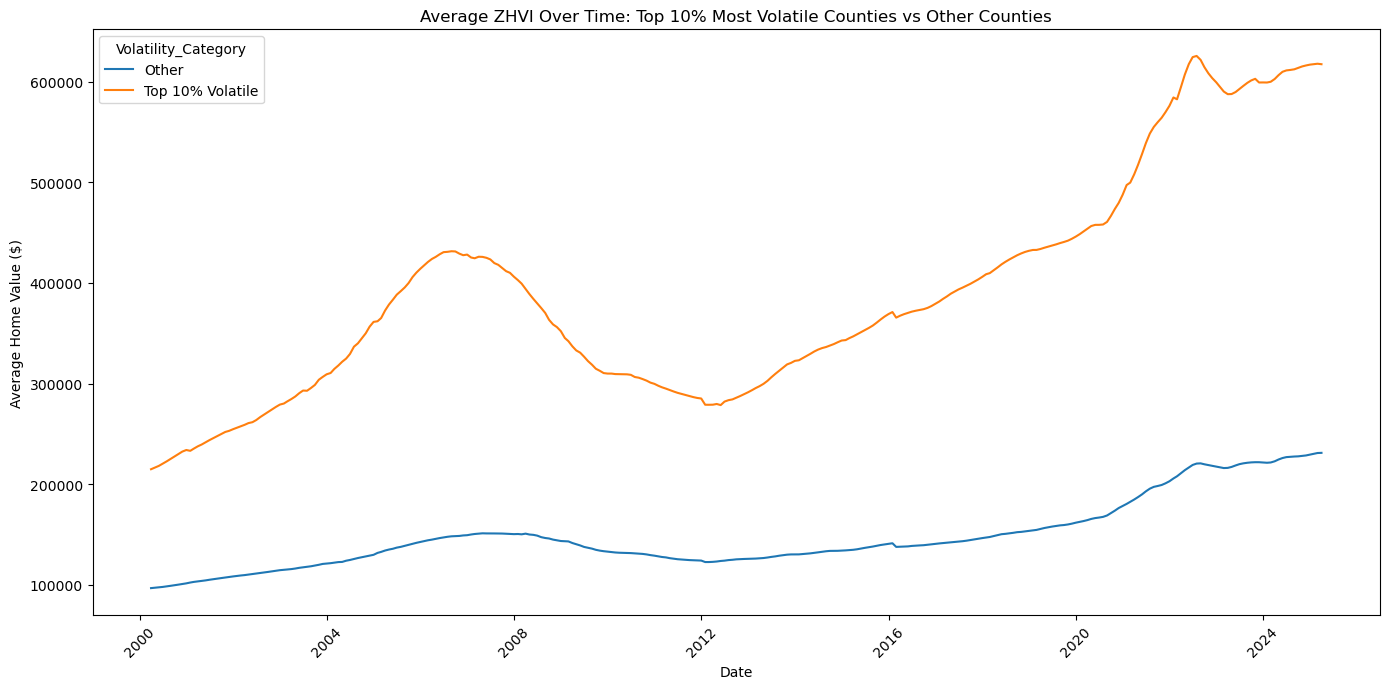

In [25]:
## Plot ZHVI trends over time for the top 10 most volatile counties

# Step 7: Plot the result
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_vol_trend_all, x='Date', y='ZHVI', hue='Volatility_Category')
plt.title('Average ZHVI Over Time: Top 10% Most Volatile Counties vs Other Counties')
plt.ylabel('Average Home Value ($)')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Figure 2: Average ZHVI Over Time – Top 10% Most Volatile Counties vs Other Counties (2000–2023)

This line graph compares the average Zillow Home Value Index (ZHVI) over time between the top 10% most volatile counties and all other U.S. counties, based on 12-month rolling standard deviation from 2000 to 2023. Counties in the top volatility group experienced sharper and more frequent fluctuations in housing prices, indicating heightened sensitivity to market dynamics, economic shocks, or localized pressures. In contrast, the majority of counties exhibited steadier, more stable growth. This visualization underscores the uneven distribution of housing market instability across the country.


/var/folders/fm/wqwsv4hx2fs6mhx28vlh_g600000gn/T/ipykernel_2167/2464640132.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rolling_std_labeled['Category'].fillna('Other', inplace=True)
/var/folders/fm/wqwsv4hx2fs6mhx28vlh_g600000gn/T/ipykernel_2167/2464640132.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mean_volatility_by_group, x='Category', y='Rolling_STD', p

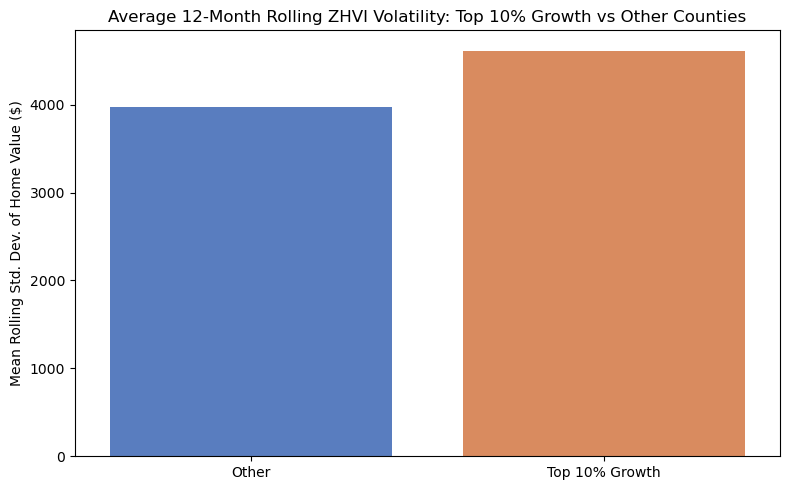

In [19]:
# Recalculate growth for all counties from Jan 2020 to Jan 2023
start = df_stacked[df_stacked['Date'] == '2020-01-31']
end = df_stacked[df_stacked['Date'] == '2023-01-31']

merged_growth = pd.merge(start, end, on=['RegionName', 'State', 'Metro'], suffixes=('_2020', '_2023'))
merged_growth['Percent_Change'] = ((merged_growth['ZHVI_2023'] - merged_growth['ZHVI_2020']) / merged_growth['ZHVI_2020']) * 100

# Define Top 10% Growth counties
threshold = merged_growth['Percent_Change'].quantile(0.90)
top_10_percent = merged_growth[merged_growth['Percent_Change'] >= threshold]['RegionName'].tolist()

# Label all counties as Top 10% or Other
growth_vol_df['Category'] = growth_vol_df['RegionName'].apply(
    lambda x: 'Top 10% Growth' if x in top_10_percent else 'Other'
)

# Merge category labels into the full rolling std dataframe
rolling_std_labeled = pd.merge(
    rolling_std_reset, 
    growth_vol_df[['RegionName', 'Category']], 
    on='RegionName', 
    how='left'
)
rolling_std_labeled['Category'].fillna('Other', inplace=True)

# Calculate mean volatility for each group
mean_volatility_by_group = rolling_std_labeled.groupby('Category')['Rolling_STD'].mean().reset_index()

# Plot bar chart of average volatility
plt.figure(figsize=(8, 5))
sns.barplot(data=mean_volatility_by_group, x='Category', y='Rolling_STD', palette='muted')
plt.title('Average 12-Month Rolling ZHVI Volatility: Top 10% Growth vs Other Counties')
plt.ylabel('Mean Rolling Std. Dev. of Home Value ($)')
plt.xlabel('')
plt.tight_layout()
plt.show()

### Figure 3: Average Housing Price Volatility – Top 10% Growth vs Other Counties

This bar chart compares the average 12-month rolling standard deviation in home values (ZHVI) between counties in the top 10% of housing price growth (2020–2023) and all other U.S. counties. The top growth counties exhibit significantly higher volatility, indicating that rapid price increases are often accompanied by greater market instability. This supports the broader finding that high-growth housing markets tend to be more sensitive to economic and structural pressures, reinforcing the connection between price appreciation and risk.


In [15]:
# Calculate long-term price growth for each county
# Using the earliest and latest available date in the grouped data
start_date = df_grouped['Date'].min()
end_date = df_grouped['Date'].max()

# Extract ZHVI at start and end for each county
start_values = df_grouped[df_grouped['Date'] == start_date]
end_values = df_grouped[df_grouped['Date'] == end_date]

# Merge and compute percent growth
growth_df = pd.merge(start_values, end_values, on='RegionName', suffixes=('_start', '_end'))
growth_df['Percent_Growth'] = ((growth_df['ZHVI_end'] - growth_df['ZHVI_start']) / growth_df['ZHVI_start']) * 100

# Merge growth data with average volatility
growth_vol_df = pd.merge(growth_df[['RegionName', 'Percent_Growth']], avg_volatility.reset_index(), on='RegionName')
growth_vol_df.rename(columns={0: 'Avg_Rolling_Std'}, inplace=True)

# Run correlation tests
pearson_corr, pearson_p = pearsonr(growth_vol_df['Percent_Growth'], growth_vol_df['Avg_Rolling_Std'])
spearman_corr, spearman_p = spearmanr(growth_vol_df['Percent_Growth'], growth_vol_df['Avg_Rolling_Std'])

# Display correlation results
correlation_results = {
    "Pearson Correlation": pearson_corr,
    "Pearson p-value": pearson_p,
    "Spearman Correlation": spearman_corr,
    "Spearman p-value": spearman_p
}

correlation_results

{'Pearson Correlation': 0.43646807502881835,
 'Pearson p-value': 3.011801544284136e-37,
 'Spearman Correlation': 0.4928168700851162,
 'Spearman p-value': 1.7583090104317454e-48}

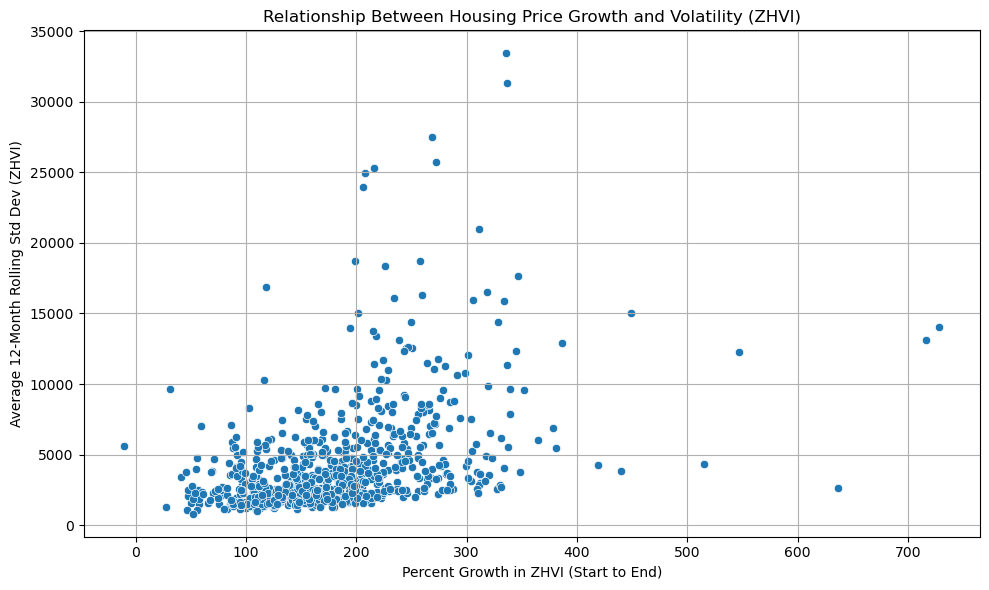

In [16]:
# Scatter plot of Percent Growth vs Average Rolling Std Deviation
plt.figure(figsize=(10, 6))
sns.scatterplot(data=growth_vol_df, x='Percent_Growth', y='Avg_Rolling_Std')
plt.title('Relationship Between Housing Price Growth and Volatility (ZHVI)')
plt.xlabel('Percent Growth in ZHVI (Start to End)')
plt.ylabel('Average 12-Month Rolling Std Dev (ZHVI)')
plt.grid(True)
plt.tight_layout()
plt.show()

### Figure 4: Relationship Between Housing Price Growth and Volatility

This scatter plot illustrates the relationship between long-term housing price growth (percent change in Zillow Home Value Index) and average 12-month rolling standard deviation (volatility) across U.S. counties. The upward trend indicates that counties with faster-growing housing markets tend to exhibit higher levels of price volatility. This finding supports the idea that rapid growth often coincides with instability, potentially reflecting speculative dynamics, demand shocks, or insufficient housing supply responses.


### Results

To explore whether rapidly growing housing markets are also more unstable, I analyzed the relationship between long-term housing price growth and price volatility across U.S. counties. Using Zillow’s Home Value Index (ZHVI) data from 2000 to 2023, we calculated:

- **Percent Growth** in median home value for each county (from 2000 to 2023)
- **Average Volatility** as the 12-month rolling standard deviation in ZHVI over the same period

A scatter plot was generated to visualize this relationship, and two statistical tests were conducted:

- **Pearson Correlation** (linear relationship): **0.44**, *p* < 0.000001  
- **Spearman Correlation** (rank-based, non-parametric): **0.49**, *p* < 0.000001  

Both results show a **moderate, statistically significant positive correlation** between housing price growth and volatility. This suggests that counties with faster-growing housing markets are also more likely to experience greater fluctuations in home values. These findings imply that rapid growth may carry hidden risks, potentially driven by speculative investment, market imbalances, or reactive local policies that lag behind demand.

This result helps quantify the tradeoff between growth and stability in local housing markets and supports the broader claim that housing markets behave dynamically in response to systemic pressures.